# Separating Mouse and Human Antibody Sequences using Protein Encoding and Machine Learning Classifiers

### Objectives:

- To use heatmaps to visualise amino acid sequences for visual distinction.

- Learn how to encode amino acid sequences from text-based information into numerical formats that can be used for machine learning.

- To train machine learning predictors to distinguish two groups of amino acid sequences.

- Measure the performance of machine learning predictors using Matthew's Correlation Coefficient.

- Compare the performance of models trained with sequences having undergone different encoding methods.

- Save encoded data and models and data for loading in future exercises.

### Introduction 

An important application of machine learning in biology is to use them to explore differences in amino acid sequences to draw meaningful conclusions, or to use them for predictions. The issue you may appreciate is that amino acid sequences are text based, which cannot be readable to the machine learning algorithm. If we want to train a classifier that can be trained on text-based sequences, we need to extract numerical information from the text, either by the level of words, or individual letters. This is called encoding.

There are a number of methods to encoding amino acid sequences. Usually a value, or set of values is assigned to represent each amino acid in the sequence. This can be done very simply by assigning each possible amino acid a number between 1 and 20 and substituting these values in the sequence, or by using a binary nx20 vector, representing each possible 20 amino acids at each residue. However, there are more complex methods of encoding these sequences including using preassigned values which encode information about the physicochemical properties of each residue, and more recently language models which are a kind of autoencoder which gives dense numerical representations of each residue in the sequence which are dynamically calculated (ElAbd *et al.*, 2020).

This notebook will explore how some of these principals can be applied to distinguish two sets of proteins. To this end, a case study of separating human and mouse antibodies has been chosen to demonstrate how sequences can be encoded, and how sequences with high conservation can be distinguished by machine learning models. In subsequent notebooks, proceedures to optimise machine learning performance will be explored. 


## Introduction to Antibodies
Antibodies are "Y" shaped proteins made up of two heavy and two light chains which can bind to a specific antigen. They have become a successful class of biologic therapeutics in cancers and autoimmune diseases as this binding ability can be used to target a molecule to inhibit or enhance a step in a disease pathway.  The functional antigen-binding domains are the Fv, variable fragments, at each fork of the "Y" shape. These Fv fragments are where the variable domains of a heavy chain, VH, and of the light chain, VL, interact and therefore much study has been dedicated to these domains. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. In the past, this knowledge was rare as it came from studying individual antibodies. However, the advent of B-cell encapsulation and Next Generation Sequencing now allows researchers to sequence a whole repertoire of paired antibodies, and thus, this data has become increasingly abundant (Rajan *et al.*, 2018).
![image info](Antibody_Figure.png "Title")<br>

A) Schematic diagram of an antibody protein
B) Ribbon of antiobdy Fv domains 


Below we give the amino acid sequences of the VH and VL domains.

```
VH = "EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSAITWNSGHIDYADSVEGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAKVSYLSTASSLDYWGQGTLVTVSS"

VL = "DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQRYNRAPYTFGQGTKVEIK"
```

Therapeutic antibodies can come from a variety of sources, a large number still come from mice and mice with humanized immune systems generating wholly human antibodies. Generating antibodies which the patient immune system will recognise as human is important to ensure an immune response will not be mounted which could lead to the therapetic being ineffective in a given patient. For this reason, it is necessary to screen antibodies for their similarity to mouse sequences as a way of predicting how likely they are to cause an immune reaction in patients.


In this Lesson, we will use a sample of 1000 human and 1000 mouse paired antibodies obtained from the Observed Antibody Space database (Olsen *et al.*, 2022) and train a machine learning classifier to tell them apart. Firstly, we will use one hot encoding, which is representing each amino acid sequence as an nx20 matrix. Secondly we will use physicochemical properties to encode sequences giving more complex encodings representing features of the amino acid sequences (Sequeira *et al.*, 2022) to generate our encodings from an input of FASTA formatted sequences. Secondly, we will split those encodings into training and test datasets for a selection of machine learning classifiers and compare the results for both methods of encoding.

### References

[ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235.](https://doi.org/10.1186/s12859-020-03546-x) 

[Nakai, K., Kidera, A., & Kanehisa, M. (1988). Cluster analysis of amino acid indices for prediction of protein structure and function. Protein Engineering, Design and Selection, 2(2), 93-100.](https://doi.org/10.1093/protein/2.2.93)

[Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired and paired antibody sequences. Protein Science, 31(1), 141–146.](https://doi.org/https://doi.org/10.1002/pro.4205)

[Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5.](https://doi.org/10.1038/s42003-017-0006-2)

[Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning. Neurocomputing, 484, 172–182.](https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102)

## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

##You will also need bio:

`pip install bio`

The machine learning models that we will use are imported from the [Scikit-Learn](https://scikit-learn.org/stable/) package. We suggest installing this via the following command: 

`pip install sklearn`

As this is a large package, rather than importing the whole package, it is better practise to just import the required fuctions. Since we need a lot of import statements, we structure these in line with the chronology of the code that we will be using.


In [31]:

RANDOM_SEED = 42

##Imports for getting encodings###
import sys
from Bio import SeqIO
from Bio import pairwise2
import re
import requests
sys.path.append('../src/')
sys.path.append('')
import pandas as pd
from pandas import read_csv
#from propythia.protein.sequence import ReadSequence
#sequence=ReadSequence()
#from propythia.protein import descriptors


##Imports for Data preparation###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import zeros, array
from matplotlib.pyplot import subplots
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed


##Importing machine learning models###
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

##Imports for model evaluation###
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
import pickle


##Imports for plotting results###
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
import seaborn as sns






## Studying the Sequences
Before starting the machine learning element of the lesson, an exploration of the antibody sequences is required to give context to how the machine learning models can assist in distinguishing between sequences. This will be done by visual inspection, and then some more detailed exploration.


In [3]:
##These functions are used for encoding amino acids and padding sequences and will be used throughout the notebook##


#Dictionary for encoding amino acids with integers
aa_decimal = {'A': 1,
'C': 2,
'D': 3,
'E': 4,
'F': 5,
'G': 6,
'H': 7,
'I': 8,
'K': 9,
'L': 10,
'M': 11,
'N': 12,
'P': 13,
'Q': 14,
'R': 15,
'S': 16,
'T': 17,
'V': 18,
'W': 19,
'Y': 20,
'X': 0
}

def Get_First_10_Sequences(fasta):
    ###Get first 10 VH and VL sequences from fasta file and save them as 2 lists###
    VH_sequences = []
    VL_sequences = []
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
        if len(VH_sequences) == 10 and len(VL_sequences) == 10:
            return(VH_sequences, VL_sequences)
   

def pad_sequences(list_of_lists, pad_char):
    ##Pad sequences to the length length of the longest sequence##
    max_length = max(len(lst) for lst in list_of_lists) 
    padded_lists = []
    for lst in list_of_lists:
        padded_lst = lst + [pad_char] * (max_length - len(lst))
        padded_lists.append(padded_lst)
    return padded_lists

def repeat_sequence_to_length(lst, length):
    ##Repeat list to a given length##
    repeated_list = []
    while len(repeated_list) < length:
        repeated_list.extend(lst[:length - len(repeated_list)])
    return repeated_list[:length]


##Print out first 10 VH and VL sequences for visual inspection. These should all be human sequences##
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'
First_10_Sequences = Get_First_10_Sequences(input_fasta)
First_10_VH_sequences = First_10_Sequences[0]
First_10_VL_sequences = First_10_Sequences[1]
for i in range(len(First_10_VH_sequences)):
    print(First_10_VH_sequences[i],First_10_VL_sequences[i])



    

QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLEWVSYISSSGSSLYYADSVMGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCASGAVTDFVYWGQGALVTVSS QSALTQPPSASGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAPKLMIYEVSKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYAGINNFRVFGGGTKLTVL
QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVANISYDGSNKYYADSVKGRLTISRDNSKNTLYLQMNSLRDEDTSMYYCAKEGPLYSSGYYFDYWGQGTLVTVSS EIVMTQSPATLSVSPGERATLSCRTSQSISSNLAWYQQKPGQAPRLLIYGASTRATGIPPRFSGSGSGTEFTLTISSLQSEDLAVYYCQQYNNLYTFGQGTKLEIK
EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLEWVGRIKSKIDGEAPDYAAPVKGRFLISRDDSNNTLYLQLTSLKTEDTAVYFCTTDRTHYYDSFYWGQGVLVTVSS EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYFAWYQQKPGQAPRLLIYDASTRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGTFFGGGTRVEIK
EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLEWVGRIKSKGGGGTVDYAAPMRGRFTISRDDSINTLYLEMNSLKSEDTGVYYCSHQIDYHYRMDFWGQGTTVTVSS QSALTQPPSASGSPGQSVTISCTGTSGDVGGHNYVTWYQQHPGKAPKLIIYEVTKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYTGTNLVFGGGTKLTVL
QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLEWVAYIRYDGNNKYYAESVKGRFTVSRDNSKNTLY

As we can see, some of the sequences have residues which align throughout all of the 10 sequences we have chosen, but this is difficult visualise by looking at the raw sequences. What could help is to visualise these sequences using a heat map, where each colour represents a different kind of amino acid. In this case, we will just pad out the end of the sequence with a dummy amino acid 'X' so they are all the same length to plot.

Text(0.5, 0, 'Amino Acid Position')

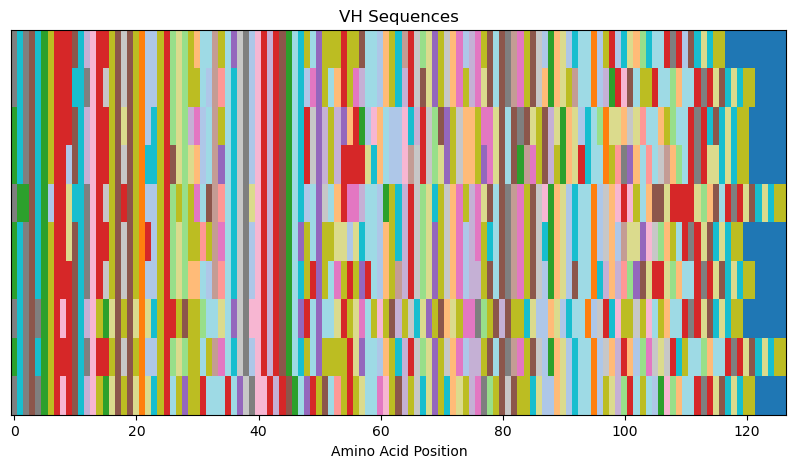

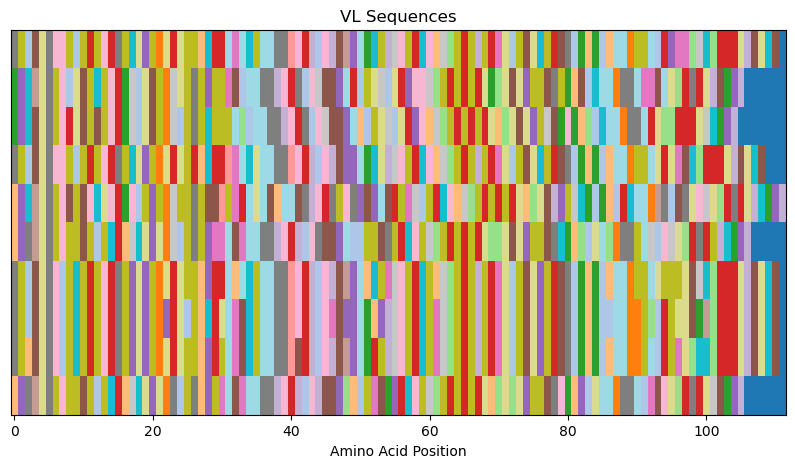

In [4]:
##Get sequences in encoded format using numerical dictionary###

First_10_VH_sequences_decimal = []
for i in range(len(First_10_VH_sequences)):
    current_seq = []
    for aa in First_10_VH_sequences[i]:
        current_seq.append(aa_decimal[aa])
    First_10_VH_sequences_decimal.append(current_seq)
First_10_VL_sequences_decimal = []
for i in range(len(First_10_VL_sequences)):
    current_seq = []
    for aa in First_10_VL_sequences[i]:
        current_seq.append(aa_decimal[aa])
    First_10_VL_sequences_decimal.append(current_seq)

#Pad sequences to the length of the longest sequence using functions above#
padded_VH_decimal = pad_sequences(First_10_VH_sequences_decimal,0)
padded_VL_decimal = pad_sequences(First_10_VL_sequences_decimal,0)
        
#Combine sequences into a single array for plotting#
VH_aa_combined = np.array((padded_VH_decimal[0],padded_VH_decimal[1],padded_VH_decimal[2],padded_VH_decimal[3],padded_VH_decimal[4],padded_VH_decimal[5],padded_VH_decimal[6],padded_VH_decimal[7],padded_VH_decimal[8],padded_VH_decimal[9]))
VL_aa_combined = np.array((padded_VL_decimal[0],padded_VL_decimal[1],padded_VL_decimal[2],padded_VL_decimal[3],padded_VL_decimal[4],padded_VL_decimal[5],padded_VL_decimal[6],padded_VL_decimal[7],padded_VL_decimal[8],padded_VL_decimal[9]))

#Plot sequences#
#VH#
fig, ax = subplots(figsize=(10, 5))

ax.imshow(VH_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VH Sequences")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position")

#VL#
fig, ax = subplots(figsize=(10, 5))

ax.imshow(VL_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position")
##put in key##



So from here, it looks like at the start of the sequences, there are points where all of the residues are aligned, but insersions in the sequence have shifted some residues out of alignment with each other. Let's try a sequence alignment using an antibody numbering scheme to try and tidy these up. What we will show is that these numbering schemes will align these sequences by arranging the pad amino acid 'X' throughout the sequences at known points where insersions and deletions occur, so each residue in a numbered sequence is in the same position as it would be on another sequence.

There are a selection of numbering schemes that have been developed for antibodies that have slight variations to where they allow insersions and deletions within the sequence. To find out more about numbering schemes, read more on [Professor Andrew Martin's website](http://www.bioinf.org.uk/abs/info.html). We will use the Chothia numbering scheme as it is seen as the most popular.

In [8]:
'''
This code has been adapted from other programmes to apply numbering schemes to antibodies for sequence alignment through requesting REST access to the AbNum website. 
This code requires Internet connection to execute. Please do not edit this code. 

'''
def annotate(aaseq, scheme):
    #Assemble URL according to sequence and numbering scheme, then retrieve annotation using REST access##
    url="http://www.bioinf.org.uk/abs/abnum/abnum.cgi"

    if scheme=="kabat":
        sche="-k"
    elif scheme=="chothia":
        sche="-c"
    

    try:
        #Try to retrieve annotation from AbNum website with requests module, save retrieved text as a list, then convert to dictionary##
        params={"plain":1, "scheme":sche, "aaseq":aaseq}
        myPage=requests.get(url, params=params)
        text=myPage.text
        lst=text.split()

        if len(lst)>1:
            #Convert list to dictionary of postition:amino acid##
            chain={lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}            
            return chain
        else:
            print("No annotation retrieved. Did you enter the complete VH or VL sequence?")
    except:
        print("An error occured in the `retrieve()` method")

def get_spaced_sequence(Heavy_seq, Light_seq, scheme):
    ##Get spaced sequences for alignment##
    try:
        seq1=annotate(Heavy_seq,scheme)
        heavy_sequence_num_list = list(seq1.keys())
        seq2=annotate(Light_seq,scheme)
        light_sequence_num_list = list(seq2.keys())
        #Whole numbering scheme printed out for reference##
        if scheme == 'kabat':
            Heavy_sorter = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24','H25','H26','H27','H28','H29','H30','H31','H32','H33','H34','H35','H35A','H35B','H36','H37','H38','H39','H40','H41','H42','H43','H44','H45','H46','H47','H48','H49','H50','H51','H52','H52A','H52B','H52C','H53','H54','H55','H56','H57','H58','H59','H60','H61','H62','H63','H64','H65','H66','H67','H68','H69','H70','H71','H72','H73','H74','H75','H76','H77','H78','H79','H80','H81','H82','H82A','H82B','H82C','H83','H84','H85','H86','H87','H88','H89','H90','H91','H92','H93','H94','H95','H96','H97','H98','H99','H100','H100A','H100B','H100C','H100D','H100E','H100F','H100G','H100H','H100I','H100J','H100K','H101','H102','H103','H104','H105','H106','H107','H108','H109','H110','H111','H112','H113']
            Light_sorter = ['L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14','L15','L16','L17','L18','L19','L20','L21','L22','L23','L24','L25','L26','L27','L27A','L27B','L27C','L27D','L27E','L27F','L28','L29','L30','L31','L32','L33','L34','L35','L36','L37','L38','L39','L40','L41','L42','L43','L44','L45','L46','L47','L48','L49','L50','L51','L52','L53','L54','L55','L56','L57','L58','L59','L60','L61','L62','L63','L64','L65','L66','L67','L68','L69','L70','L71''L72','L73','L74','L75','L76','L77','L78','L79','L80','L81','L82','L83','L84','L85','L86','L87','L88','L89','L90','L91','L92','L93','L94','L95','L95A','L95B','L95C','L95D','L95E','L95F','L96','L97','L98','L99','L100','L101','L102','L103','L104','L105','L106','L106A','L107','L108','L109']
        elif scheme == 'chothia':
            Heavy_sorter = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24','H25','H26','H27','H28','H29','H30','H31','H31A','H31B','H32','H33','H34','H35','H36','H37','H38','H39','H40','H41','H42','H43','H44','H45','H46','H47','H48','H49','H50','H51','H52','H52A','H52B','H52C','H53','H54','H55','H56','H57','H58','H59','H60','H61','H62','H63','H64','H65','H66','H67','H68','H69','H70','H71','H72','H73','H74','H75','H76','H77','H78','H79','H80','H81','H82','H82A','H82B','H82C','H83','H84','H85','H86','H87','H88','H89','H90','H91','H92','H93','H94','H95','H96','H97','H98','H99','H100','H100A','H100B','H100C','H100D','H100E','H100F','H100G','H100H','H100I','H100J','H100K','H101','H102','H103','H104','H105','H106','H107','H108','H109','H110','H111','H112','H113']
            Light_sorter = ['L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14','L15','L16','L17','L18','L19','L20','L21','L22','L23','L24','L25','L26','L27','L28','L29','L30','L30A','L30B','L30C','L30D','L30E','L30F','L31','L32','L33','L34','L35','L36','L37','L38','L39','L40','L41','L42','L43','L44','L45','L46','L47','L48','L49','L50','L51','L52','L53','L54','L55','L56','L57','L58','L59','L60','L61','L62','L63','L64','L65','L66','L67','L68','L69','L70','L71','L72','L73','L74','L75','L76','L77','L78','L79','L80','L81','L82','L83','L84','L85','L86','L87','L88','L89','L90','L91','L92','L93','L94','L95','L95A','L95B','L95C','L95D','L95E','L95F','L96','L97','L98','L99','L100','L101','L102','L103','L104','L105','L106','L106A','L107','L108','L109']
        else:
            print("no scheme provided")
            quit()
        ##For VH and VL sequences, if the position is not in the numbering scheme, replace with X to space sequence to the length of the whole number scheme##
        spaced_heavy_seq = ""
        for x in range(len(Heavy_sorter)):
            if Heavy_sorter[x] not in heavy_sequence_num_list:
                spaced_heavy_seq += "X"
            elif Heavy_sorter[x] in heavy_sequence_num_list:
                spaced_heavy_seq += str(seq1.get(Heavy_sorter[x]))


        spaced_light_seq = ""
        for x in range(len(Light_sorter)):
            if Light_sorter[x] not in seq2:
                spaced_light_seq += "X"
            elif Light_sorter[x] in light_sequence_num_list:
                spaced_light_seq += str(seq2.get(Light_sorter[x]))
        return(spaced_heavy_seq,spaced_light_seq)
    except:
        pass


##Get spaced sequences for alignment with Chothia numbering scheme and save spaced sequences as list of VH and VL ##
Spaced_VH_seqs = []
Spaced_VL_seqs = []
for i in range(len(First_10_VH_sequences)):
    spaced_sequences = get_spaced_sequence(str(First_10_VH_sequences[i]),str(First_10_VL_sequences[i]), "chothia")
    Spaced_VH_seqs.append(spaced_sequences[0])
    Spaced_VL_seqs.append(spaced_sequences[1])
    

Text(0.5, 0, 'Amino Acid Position (Chothia Numbering Scheme)')

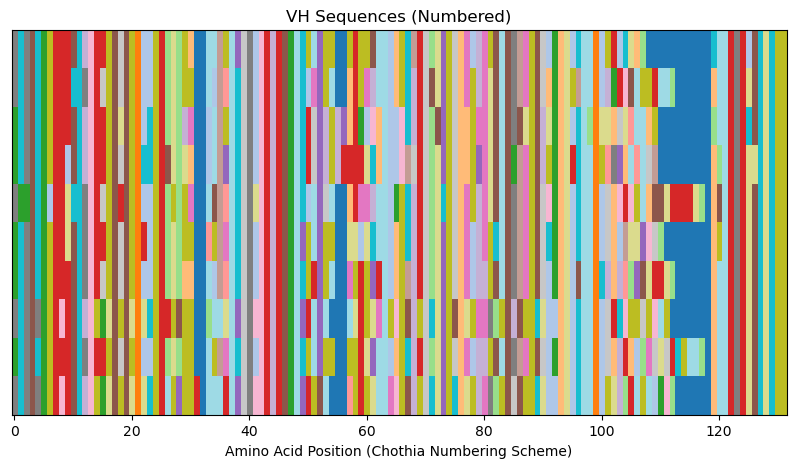

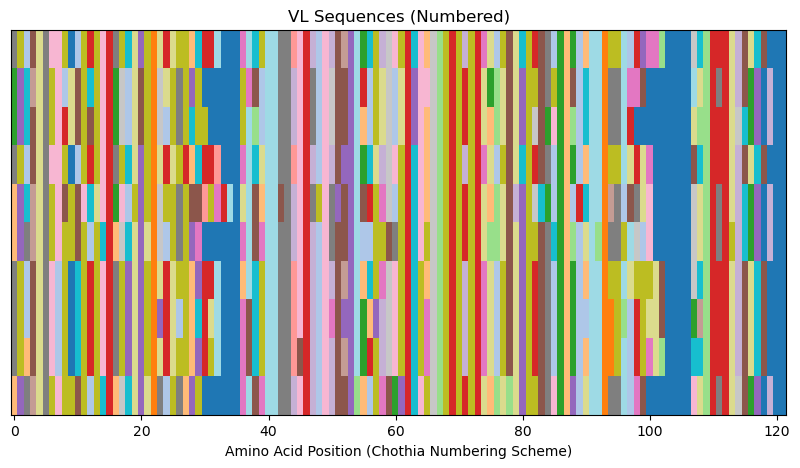

In [9]:
##Encode spaced sequences with numerical encodings and pad##
Spaced_VH_seqs_decimal = []
for i in range(len(Spaced_VH_seqs)):
    current_seq = []
    for aa in Spaced_VH_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Spaced_VH_seqs_decimal.append(current_seq)
    
Spaced_VL_seqs_decimal = []
for i in range(len(Spaced_VL_seqs)):
    current_seq = []
    for aa in Spaced_VL_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Spaced_VL_seqs_decimal.append(current_seq)

#Combine sequences into a single array for plotting#
VH_aa_combined = np.array((Spaced_VH_seqs_decimal[0],Spaced_VH_seqs_decimal[1],Spaced_VH_seqs_decimal[2],Spaced_VH_seqs_decimal[3],Spaced_VH_seqs_decimal[4],Spaced_VH_seqs_decimal[5],Spaced_VH_seqs_decimal[6],Spaced_VH_seqs_decimal[7],Spaced_VH_seqs_decimal[8],Spaced_VH_seqs_decimal[9]))
VL_aa_combined = np.array((Spaced_VL_seqs_decimal[0],Spaced_VL_seqs_decimal[1],Spaced_VL_seqs_decimal[2],Spaced_VL_seqs_decimal[3],Spaced_VL_seqs_decimal[4],Spaced_VL_seqs_decimal[5],Spaced_VL_seqs_decimal[6],Spaced_VL_seqs_decimal[7],Spaced_VL_seqs_decimal[8],Spaced_VL_seqs_decimal[9]))

#Plot sequences#
#VH
fig, ax = subplots(figsize=(10, 5))

ax.imshow(VH_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VH Sequences (Numbered)")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")

#VL
fig, ax = subplots(figsize=(10, 5))

ax.imshow(VL_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences (Numbered)")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")



This looks much better! Now there are aligned residues throughout the sequences. So in conclusion, this section has demonstrated the points of diversity within VH and VL antibody sequences and how numbering schemes help to align siquences better than traditional sequence alignments or padding out sequences. Using the human sequences we have studied here and 10 representative mouse sequences, we will plot these sequences side by side and try to observe visual differences which represent differences in their sequences.

In [10]:
##Get first 10 Mouse VH and VL paried sequences##
input_fasta_mouse = './Mouse_1000_paired_sequences.faa.txt'
First_10_Mouse_Sequences = Get_First_10_Sequences(input_fasta_mouse)
First_10_Mouse_Sequences_VH = First_10_Mouse_Sequences[0]
First_10_Mouse_Sequences_VL = First_10_Mouse_Sequences[1]
Mouse_Spaced_VH_seqs = []
Mouse_Spaced_VL_seqs = []

#Space sequences to Chothia numbering scheme and save as list of VH and VL sequences##
for i in range(len(First_10_Mouse_Sequences_VH)):
    spaced_sequences = get_spaced_sequence(str(First_10_Mouse_Sequences_VH[i]), str(First_10_Mouse_Sequences_VL[i]), "chothia")
    Mouse_Spaced_VH_seqs.append(str(spaced_sequences[0]))
    Mouse_Spaced_VL_seqs.append(str(spaced_sequences[1]))

#Encode spaced sequences with numerical encodings and pad##    
Mouse_Spaced_VH_seqs_decimal = []
for i in range(len(Mouse_Spaced_VH_seqs)):
    current_seq = []
    for aa in Spaced_VH_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Mouse_Spaced_VH_seqs_decimal.append(current_seq)
    
Mouse_Spaced_VL_seqs_decimal = []
for i in range(len(Mouse_Spaced_VL_seqs)):
    current_seq = []
    for aa in Spaced_VL_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Mouse_Spaced_VL_seqs_decimal.append(current_seq)



Text(0.5, 0, 'Amino Acid Position (Chothia Numbering Scheme)')

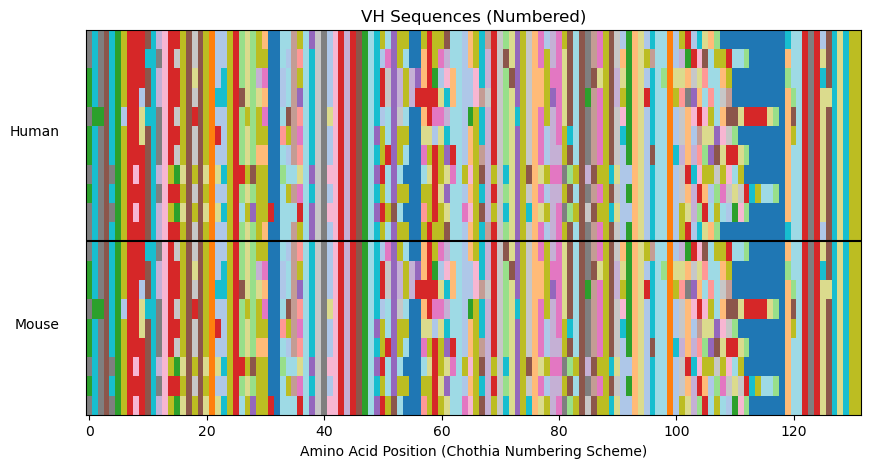

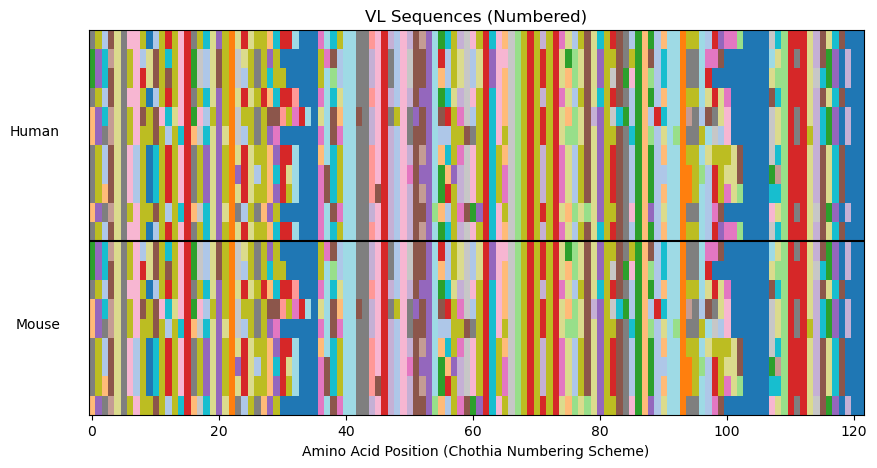

In [11]:

##Combine previously encoded and spaced Human and Mouse sequences for visualisation##
VH_aa_combined_human_mouse = np.array((Spaced_VH_seqs_decimal[0],Spaced_VH_seqs_decimal[1],Spaced_VH_seqs_decimal[2],Spaced_VH_seqs_decimal[3],Spaced_VH_seqs_decimal[4],Spaced_VH_seqs_decimal[5],Spaced_VH_seqs_decimal[6],Spaced_VH_seqs_decimal[7],Spaced_VH_seqs_decimal[8],Spaced_VH_seqs_decimal[9],Mouse_Spaced_VH_seqs_decimal[0],Mouse_Spaced_VH_seqs_decimal[1],Mouse_Spaced_VH_seqs_decimal[2],Mouse_Spaced_VH_seqs_decimal[3],Mouse_Spaced_VH_seqs_decimal[4],Mouse_Spaced_VH_seqs_decimal[5],Mouse_Spaced_VH_seqs_decimal[6],Mouse_Spaced_VH_seqs_decimal[7],Mouse_Spaced_VH_seqs_decimal[8],Mouse_Spaced_VH_seqs_decimal[9]))
VL_aa_combined_human_mouse = np.array((Spaced_VL_seqs_decimal[0],Spaced_VL_seqs_decimal[1],Spaced_VL_seqs_decimal[2],Spaced_VL_seqs_decimal[3],Spaced_VL_seqs_decimal[4],Spaced_VL_seqs_decimal[5],Spaced_VL_seqs_decimal[6],Spaced_VL_seqs_decimal[7],Spaced_VL_seqs_decimal[8],Spaced_VL_seqs_decimal[9],Mouse_Spaced_VL_seqs_decimal[0],Mouse_Spaced_VL_seqs_decimal[1],Mouse_Spaced_VL_seqs_decimal[2],Mouse_Spaced_VL_seqs_decimal[3],Mouse_Spaced_VL_seqs_decimal[4],Mouse_Spaced_VL_seqs_decimal[5],Mouse_Spaced_VL_seqs_decimal[6],Mouse_Spaced_VL_seqs_decimal[7],Mouse_Spaced_VL_seqs_decimal[8],Mouse_Spaced_VL_seqs_decimal[9]))

#VH
fig, ax = subplots(figsize=(10, 5))
ax.imshow(VH_aa_combined_human_mouse, aspect='auto', cmap='tab20')
ax.axhline(y=10.5, color='black', linestyle='-') #Insert line to separate human and mouse sequences
ax.text(-5, 5, f'Human', color='black', ha='right')
ax.text(-5, 15, f'Mouse', color='black', ha='right')
ax.yaxis.set_visible(False) 
ax.set_title("VH Sequences (Numbered)")
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")

#VL
fig, ax = subplots(figsize=(10, 5))
ax.imshow(VL_aa_combined_human_mouse, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences (Numbered)")
ax.axhline(y=10.5, color='black', linestyle='-') #Insert line to separate human and mouse sequences
ax.text(-5, 5, f'Human', color='black', ha='right')
ax.text(-5, 15, f'Mouse', color='black', ha='right')
ax.yaxis.set_visible(False) 
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")


So from this experiment, we can conclude that there are many similarities between human and mouse sequences that mean it is difficult to tell then apart by eye. However, we can use the basis for what we have learned so far and apply these to use machine learning to separate mouse and human sequences using sequence encoding.

## Generating the Encoded Sequences

Here we input our fasta sequences and split the entries into VH and VL sequences. We will then run each set of sequences into the One Hot Encoding. The Encodings for each kind of residue has been saved in the OneHotEncoding dictionary. There are 4000 records in the fasta file representing 2000 paired antibodies. 1000 of these are human and 1000 are mouse.

In [12]:
def Get_OHE_Encoded_Sequences(fasta):
    ##Read all VH and VL sequences in the input FASTA file and encode them using One Hot Encoding##
    
    #Read sequences from FASTA file and save them as lists of VH and VL sequences##
    VH_sequences = []
    VL_sequences = []
    OneHotEncoding = {"A": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "C": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "D": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "E": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "F": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "G": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "H": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "I": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "K": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "L": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "M": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "N": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], "P": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], "Q": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], "R": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], "S": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "T": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], "V": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], "W": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], "Y": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "X": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
            
   #Encode sequences using One Hot Encoding##
    if len(VH_sequences) == len(VL_sequences):
        VH_encodings = []
        VL_encodings = []
        for i in range(len(VH_sequences)):
            VH_OHE = []
            for res in VH_sequences[i]:
                VH_OHE = VH_OHE + OneHotEncoding[res]
            VH_encodings.append(VH_OHE)
        for i in range(len(VL_sequences)):
            VL_OHE = []
            for res in VL_sequences[i]:
                VL_OHE = VL_OHE + OneHotEncoding[res]
            VL_encodings.append(VL_OHE)
    
    #Pad sequences to the length of the longest sequence##
    VH_dataframe = pd.DataFrame(VH_encodings)
    VL_dataframe = pd.DataFrame(VL_encodings)
    VH_labels = []
    VH_labels_list = repeat_sequence_to_length(list(OneHotEncoding.keys()),VH_dataframe.shape[1])
    for i in range(len(VH_labels_list)):
        position = round((i+1)/21)
        VH_labels.append("VH_position_"+str(position)+"_residue_"+str(VH_labels_list[i]))
    VL_labels = []
    VL_labels_list = repeat_sequence_to_length(list(OneHotEncoding.keys()),VL_dataframe.shape[1])
    for i in range(len(VL_labels_list)):
        position = round((i+1)/21)
        VL_labels.append("VL_position_"+str(position)+"_residue_"+str(VL_labels_list[i]))
   
            
    #Join VH and VL dataframes together so that each sample now has information about its VH and VL sequence#
    VH_dataframe.columns = VH_labels
    VL_dataframe.columns = VL_labels
    joined_dataframe_VH_VL =  VH_dataframe.join(VL_dataframe)
    joined_dataframe_VH_VL_cleaned = joined_dataframe_VH_VL.dropna(axis=1)
    joined_dataframe_VH_VL_cleaned.to_csv('Human_Mouse_VH_VL_OHE.csv')
    return(joined_dataframe_VH_VL_cleaned)


In [13]:
#Specify input Fasta and get One Hot Encoded sequences##
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'
joined_dataframe_VH_VL = Get_OHE_Encoded_Sequences(input_fasta)
print(joined_dataframe_VH_VL.shape)
print(joined_dataframe_VH_VL.head(10))


(2000, 3738)
   VH_position_0_residue_A  VH_position_0_residue_C  VH_position_0_residue_D  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   
5                        0                        0                        0   
6                        0                        0                        0   
7                        0                        0                        0   
8                        0                        0                        0   
9                        0                        0                        0   

   VH_position_0_residue_E  VH_position_0_residue_F  VH_position_0_residue_G  \
0                        0

Now we have our encodings and we need to prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing only these:

In [14]:
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels

##Check that number of labels and number of samples are the same##
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0'] #Remove indexing column that could bias predictions
print(len(y) == dataset.shape[0]) 


True


Now that we have our datasets, we may split them into training datasets for fitting and testing datasets to verify their effectiveness as predictors. A 70/30 or 80/20 split can be used.

In [15]:
#Get Train/Test split of encoded data##
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape

print("Training set: ", X_train.shape, "       Test set: ", X_test.shape)


Training set:  (1400, 3738)        Test set:  (600, 3738)


## Separating our data with Machine Learning Classifiers

Next we can import the classifiers that we will be used for testing:


In [16]:
n=2
##Establish a dictionary of machine learning classifiers##
classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),                                        #Support vector machine
    'SVC2': SVC(gamma=2, C=1),                                                  #Support vector machine
    'DecisionTree': DecisionTreeClassifier(max_depth=5),                        #Decision Tree
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),#Random Forest
    'MLPC': MLPClassifier(alpha=1, max_iter=1000, random_state=42),             #Multi-layer Perceptron
    'ADABoost':AdaBoostClassifier(),                                            #AdaBoost
    'GaussianNB': GaussianNB(),                                                 #Gaussian Naive Bayes
    'QDA':QuadraticDiscriminantAnalysis(),                                      #Quadratic Discriminant Analysis
}

To train and test these classifiers, we can loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. We have chosen the Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by as it accounts for both true and false predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood (random labelling). 

We then plot the result as a confusion matrix, demonstrating the predictive power of our classifiers. The Confusion matrix shows the raw number of records that have been assigned to each category in a 2x2 matrix and is given as such: 

|                  | Predicted Class = 0  | Predicted Class = 1 |
|------------------|----------------------|---------------------|
| Actual Class = 0 | True Negative        | False Positive      |
| Actual Class = 1 | False Negative       | True Positive       |

Ideally we want the True Negative and True Positive field to be the most popular fields with none or few records in the False Positive and False Negative fields.

Note that results may vary between each run due to the stochastic nature of the machine learning algorithms.

To evaluate the performance of classifiers, Mattews Correlation Coefficient (MCC) was chosen as a suitable statistic which is a more reliable measure of how well the classifier predicts true positive and true negative results than raw accuracy.

$MCC = \frac{(TP * TN - FP * FN)}{ \sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}$


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


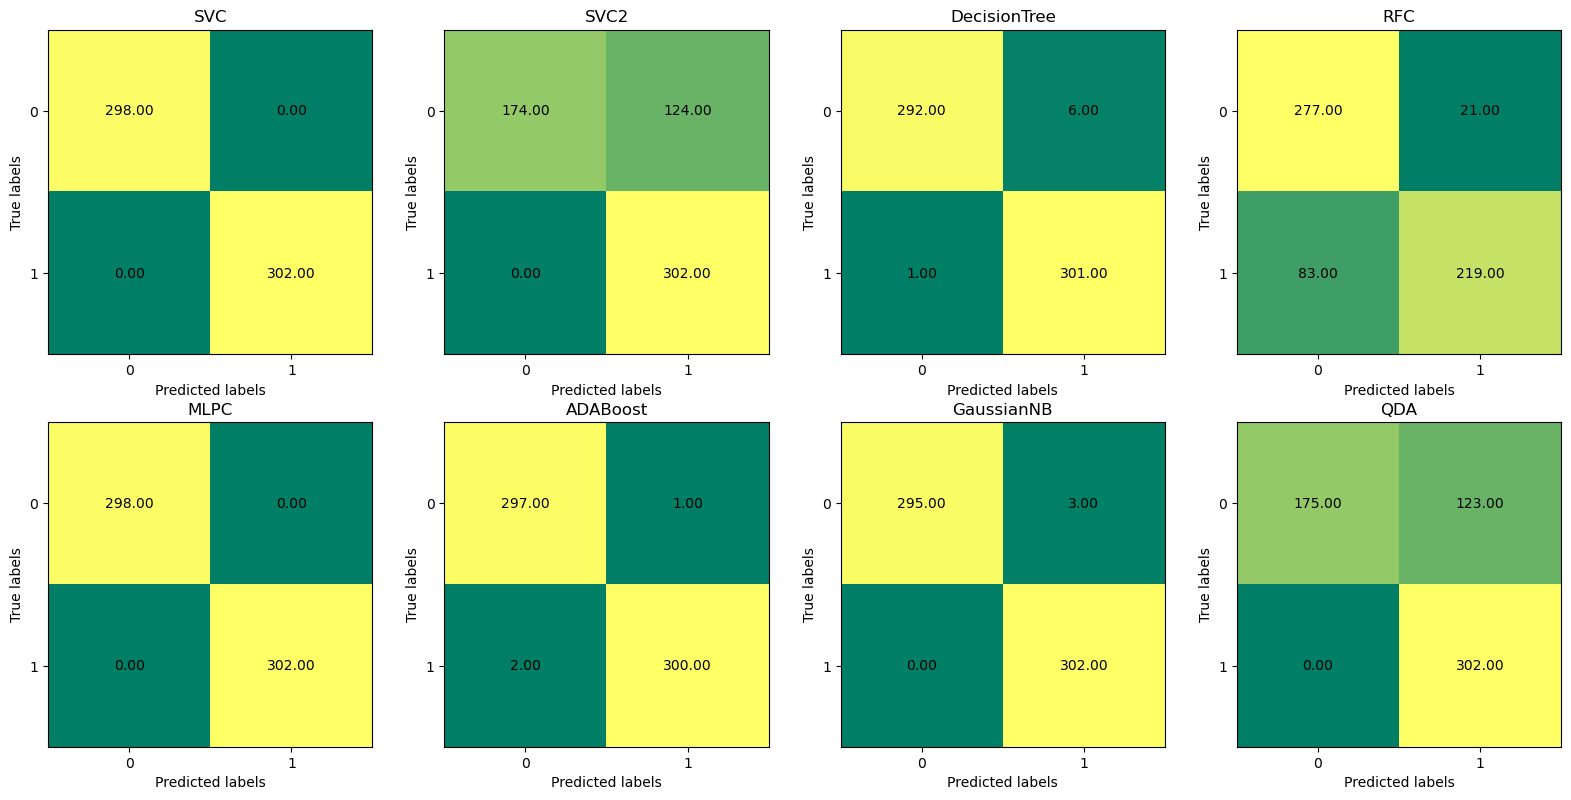

In [17]:
##Loop through each classifier, fit training data and evaluate model. Plot results as a set of confusion matrix##
class_labels = ["0","1"]
no_classifiers = len(classifiers)
OHE_scores = []
confusion_matrices = []


import seaborn as sns
#Fit models against training data and evaluate against test data#
for i in range(len(list(classifiers.keys()))):
    clf        = classifiers.get(list(classifiers.keys())[i])
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    scoring_acc = accuracy_score(y_test, y_predict)
    scoring    = matthews_corrcoef(y_test, y_predict)
    OHE_scores.append(scoring) 
    cf_matrix = metrics.confusion_matrix(y_test, y_predict)
    confusion_matrices.append(cf_matrix)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot confusion matrices as 2 x 4 grid of figures
for i, ax in enumerate(axes.flat):
    ax.imshow(confusion_matrices[i], cmap='summer')
    ax.set_title(list(classifiers.keys())[i])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.grid(False)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    

    # Annotate numerical values
    for j in range(confusion_matrices[i].shape[0]):
        for k in range(confusion_matrices[i].shape[1]):
            ax.text(k, j, f'{confusion_matrices[i][j, k]:.2f}', ha='center', va='center', color='black')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


[1.   0.64 0.98 0.67 1.   0.99 0.99 0.65]


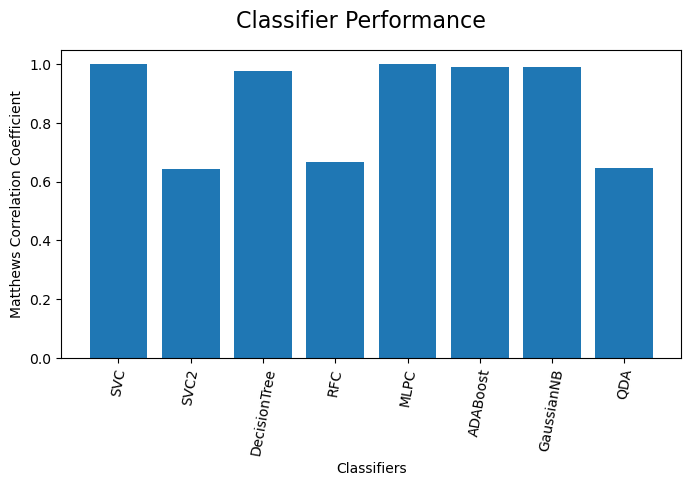

In [26]:
##Plot Performance of all models as bar char##
fig, ax = plt.subplots(figsize=(8, 4))
plt.suptitle('Classifier Performance', fontsize=16)

bins = arange(len(classifiers))
ax.bar(arange(len(OHE_scores)), OHE_scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers', fontsize=10)
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=80)

print(np.around(OHE_scores, 2))

As we can see, the majority of these classifiers have successfully learned to classify the two groups of protein structure, with nearly perfect performance in the SVC model, the neural network MLPC, and ADABoost. It is evident that there are highly correlated features in the training data which the models have exploited. However, the Kidera factor is not the only method of encoding sequences for machine learning algorithms. In fact, for more complex problems, deeper methods of encoding may be required.

### Using Physicochemical Properties to Encode Protein Sequences

Another method of encoding amino acid sequences is by using physicochemical properties associated with that residue. This could include stability, hydrophobicity, isoelectricity, rotation amongst others. These could be calculated using predetermined experimental values, or through computational approaches which are more complex than the basic level of encoding as seen in the One Hot Encoding. These properties for encoding will be calculated with the ProPythia software to generate more complex encodings and this section of the workbook, the performance of predictive models will be assessed as to how they learn to distinguish human and mouse antibodies with these encodings. 


In [19]:
def Get_dataset(fasta):
    ##Read all VH and VL sequences in the input FASTA file and encode them using physicochemical properties##
    
    ###Propythia Command to get encodings###
    def get_descriptors(protein):
        ##This will retrieve a selection of encodings that are not dependent on the sequence length##
        test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
        return(test)
    
    #Read sequences from FASTA file and save them as lists of VH and VL sequences##
    VH_sequences = []
    VL_sequences = []
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
            
   #Encode sequences using physicochemical properties##
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VH_dataframe = VH_dataframe._append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VL_dataframe = VL_dataframe._append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    
    #Join the VH and VL dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


In [20]:
### Input Fasta
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'

##Run encoding, but be warned, this could take a while##
#joined_dataframe_VH_VL = Get_dataset(input_fasta)

###Optionally save dataframe as a CSV to simply reload it in future###
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)

### Do it yourself
- The Propythia encodings were selected to reduce the time taken to run. Retry the encoding step and experiment with the protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]) array.

- Note that Propythia accepts numbers from 0-40 however we avoid 1, 2 and 37 as these produce outputs of differing length unless you are confident in spacing the sequences with the number function above

In [21]:
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels

##Just to check that you have an equal number of labels to the number of samples
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) 


(2000, 890)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


### Do it yourself
- The list of classifiers used above is not exhaustive. These were picked to represent the major classes of models. You will find a much larger list of classifiers supported in scikit-learn here: https://scikit-learn.org/stable/supervised_learning.html.

- Try adding some new classifiers to the classifier dictionary and check how the results differ.


In [23]:

n=2
##These are the same classifiers as uesd above##
classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}

In [27]:
##Loop through classifiers and fit training data, then evaluate against test data##
##This is the same as above, but with a different encoding method##
PC_scores = []
for i in range(len(list(classifiers.keys()))):
    clf        = classifiers.get(list(classifiers.keys())[i])
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    scoring_acc = accuracy_score(y_test, y_predict)
    scoring    = matthews_corrcoef(y_test, y_predict)
    PC_scores.append(scoring) 

/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[Text(0, 0, 'SVC'),
 Text(1, 0, 'SVC2'),
 Text(2, 0, 'DecisionTree'),
 Text(3, 0, 'RFC'),
 Text(4, 0, 'MLPC'),
 Text(5, 0, 'ADABoost'),
 Text(6, 0, 'GaussianNB'),
 Text(7, 0, 'QDA')]

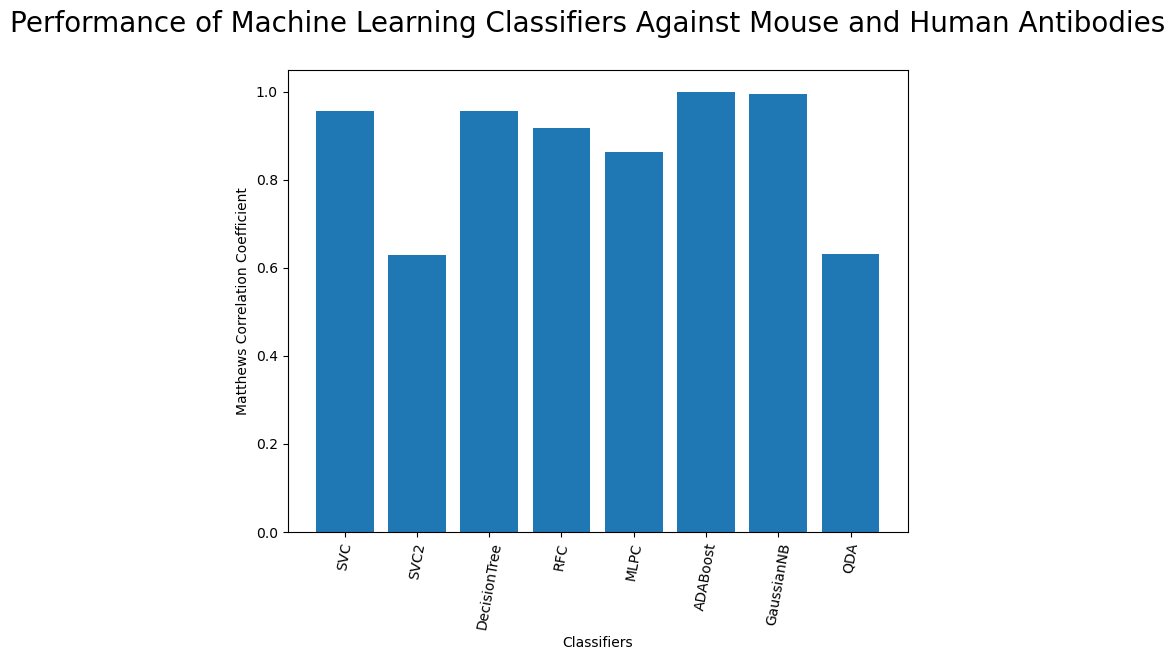

In [28]:
##Plot Performance of all Models as bar chart##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)
bins = arange(len(classifiers))
ax.bar(arange(len(PC_scores)), PC_scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=80)


The above chart indicates that the best performing predictors are ADABoost, GaussianNB, DecisionTree and SVC are the best performing classifiers, wheras KMeans is the worst performing with negative MCC scores.




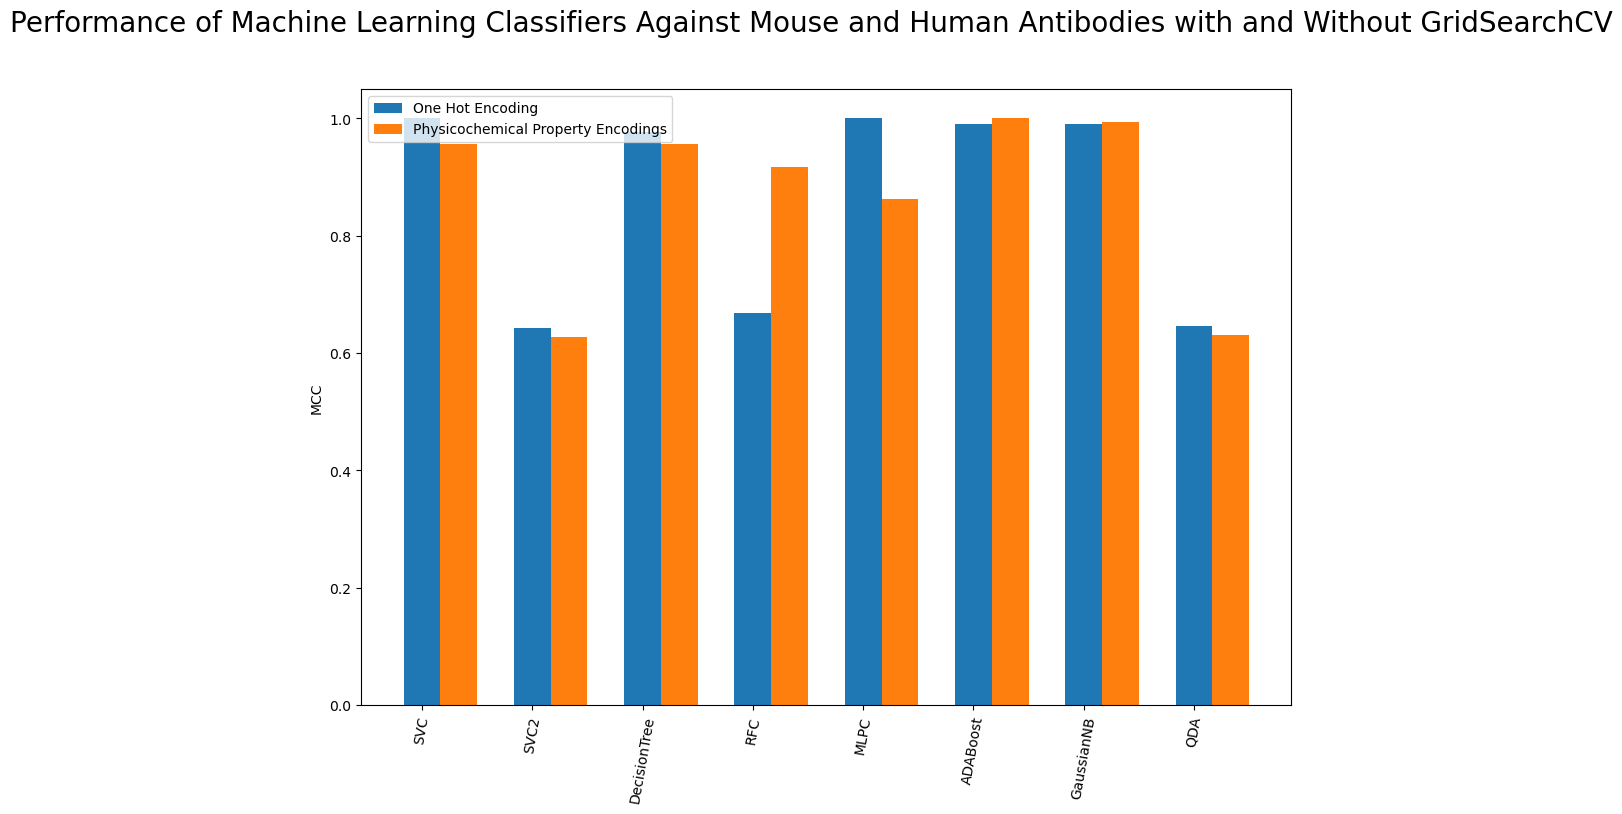

In [30]:
#Plot bar chart with two values per category as so#
fig, ax = plt.subplots(figsize=(12,8))
aranged = np.arange(len(classifiers.keys())) 
width = 1/3

bar1 = plt.bar(aranged, OHE_scores, width,label = 'One Hot Encoding')
bar2 = plt.bar(aranged+width,  PC_scores, width,label = 'Physicochemical Property Encodings')

plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=80)


plt.legend()
plt.show()

From this plot, it can be concluded that overall the performance of the machine learning classifiers predicting if an antibody is closer to human or mouse is similar between the One Hot Encoding encoded antibodies and the antibodies encoded with physicochemical properties. This is especially the case for the SVC, ADABoost and GaussianNB classifiers, which achieve very high performance. This probably means there are very obvious sequence differences between mouse and human antibodies which can be encoded with very basic methods, but which are also too subtle to be observed using inspection. However, there is still poorer performance between the SVC2 and QDA classifiers, so how can this be improved? This will be explored in the next part of this lesson.

## Saving Classifiers

It may be the case that you would want to save the classifiers trained for use in a different script as we shortly will in part two of this exercise. To do this, the code below will retrain the classifiers trained for the physicochemical encodings and then save them using the Pickle module. However, we can use the whole dataset rather than using a train test split

In [37]:
for i in classifiers.keys():
    clf        = classifiers[i]
    clf.fit(X_train,y_train)
    
    filename = f"{i}.pkl"
    with open (filename, 'wb') as f:
        pickle.dump(clf, f)
    


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Questions
- Which encoding method produced the best results overall? Why could this be? Hint: think of the size of both sets of encodings
- What could be the advantages and disadvantages of both sets of encodings?


## End of Chapter Exercise: Testing Classifiers on a Naïve Dataset

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings.

We can also take a totally naïve dataset that the model has not been exposed to. This is a measure that checks for overfitting and checking that the model is more generalisable to other kinds of data it made be needed for, not just what was used to train and test it. If we see that there is poor performance on this naïve "held back" dataset, then it could suggest overfitting to the training data. 

In our case, we can use antibody sequences from other online sources. Using 20 Human and 20 mouse paired sequences from AbYsis, another antibody sequence repository, which were not used to train or test our models, it is possible to generate their encodings, and pass them through the optimised model, in order to test it.  The file below has 20 human and 20 mouse sequences which are held back from our original training data. Using the skills you have learned so far in this notebook, encode these paired sequences and generate a list of labels for these entries. Pass them through the trained classifiers and evaluate their performance.

- Comment on which classifier performs best.
- Think of ways in which the classifiers can be improved. These will be expanded upon in the next Notebook.

`naive_fasta = './Naive_dataset.faa.txt'`


## Summary
The above exercise should have demonstrated that it is possible to use encoding methods to transform text-based protein sequences into numerical data that can be used for machine learning. This can be used to distingiush between two groups of proteins as given in our example.

## Keypoints

- Protein sequences must be numerically encoded to be readable by machine learning algorithms.
- It is necessary to test your classifier with multiple models and multiple encoding methods to find which works the best